In [1]:

Data_path = '../data_sets/PLAID/'
%ls $Data_path


CSV/  debug/  meta1.json  test/  train/


In [2]:


import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:


csv_path = Data_path + 'CSV/'
csv_files = os.listdir(csv_path)

In [4]:

import subprocess

def read_data_given_id(path,ids,progress=False,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress:
                print('%d/%d is being read...'%(i,n))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',
                delimiter=',',names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(offset)),path+
                    str(ist_id)+'.csv'],stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',
                    names='current,voltage',dtype=(float,float))
        return data



In [5]:

import json

with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)


meta = [meta1]
meta1[0]



{u'id': u'1',
 u'meta': {u'appliance': {u'brand': u'',
   u'current': u'',
   u'manufacture_year': u'',
   u'model_number': u'',
   u'notes': u'',
   u'voltage': u'',
   u'wattage': u''},
  u'header': {u'collection_time': u'July, 2013',
   u'notes': u'some instances are not well calibrated, meta data are not complete',
   u'sampling_frequency': u'30000Hz'},
  u'instances': {u'length': u'2.00s', u'status': u'off-on'},
  u'location': u'house1',
  u'type': u'Compact Fluorescent Lamp'}}

In [6]:


def clean_meta(ist):
    '''remove '' elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
#         if 
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M
     
Meta = parse_meta(meta)    
Meta[1000]

{u'appliance': {u'brand': u'',
  u'current': u'',
  u'manufacture_year': u'',
  u'model_number': u'',
  u'notes': u'',
  u'voltage': u'',
  u'wattage': u''},
 u'header': {u'collection_time': u'July, 2013',
  u'notes': u'some instances are not well calibrated, meta data are not complete',
  u'sampling_frequency': u'30000Hz'},
 u'instances': {u'length': u'2.00s', u'status': u'off-on'},
 u'location': u'house51',
 u'type': u'Laptop'}

In [7]:
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
print(Unq_type)

# appliances
Apps = [x['meta']['type'] for x in meta1]

print('number of total instances: %d' % len(Types))
print('number of unique appliances: %d' % len(Apps))
print('number of unique appliance types: %d' % len(Unq_type))

[u'Air Conditioner', u'Compact Fluorescent Lamp', u'Fan', u'Fridge', u'Hairdryer', u'Heater', u'Incandescent Light Bulb', u'Laptop', u'Microwave', u'Vacuum', u'Washing Machine']
number of total instances: 1074
number of unique appliances: 1074
number of unique appliance types: 11


In [8]:
print('%25s\t%8s' % ('Appliance Type','# instances'))
for t in Unq_type:
    t_ids = [i for i,j in enumerate(Types) if j == t]
    print('%25s\t%10d' % (t,len(t_ids)))

           Appliance Type	# instances
          Air Conditioner	        66
 Compact Fluorescent Lamp	       175
                      Fan	       115
                   Fridge	        38
                Hairdryer	       156
                   Heater	        35
  Incandescent Light Bulb	       114
                   Laptop	       172
                Microwave	       139
                   Vacuum	        38
          Washing Machine	        26


In [9]:
# get 10 random instances from each type, will take ~ 2min to run
import random

count = 10
num_type = len(Unq_type)
fs = 30000

ids_to_draw = {}
t_data = {}
for (ii,t) in enumerate(Unq_type):
    t_ids = [i for i,j in enumerate(Types,start=1) if j == t]
    ids_to_draw[t] = random.sample(t_ids, count)
    t_data[t] = read_data_given_id(csv_path, ids_to_draw[t], False)


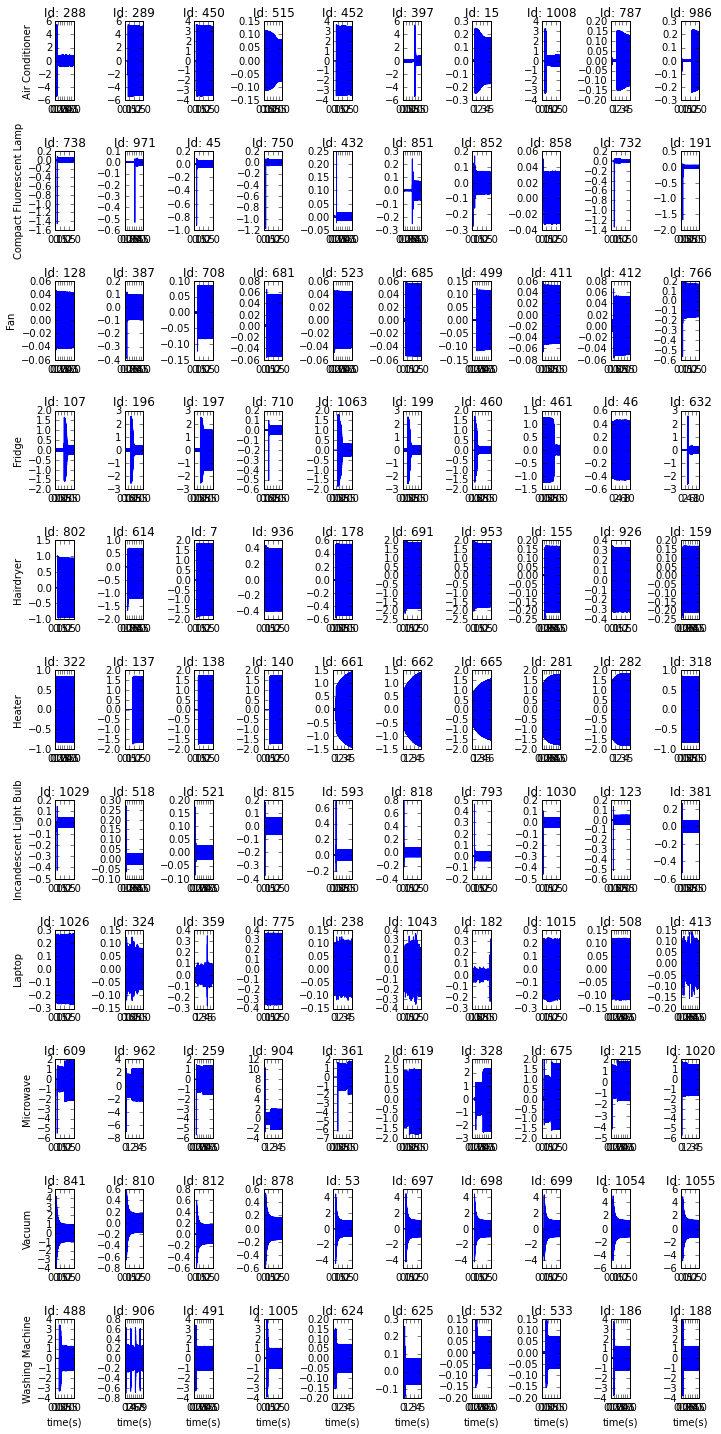

In [10]:


# plot current
fig = plt.figure(figsize=(10,20))
ids_to_draw = {}
for (ii,t) in enumerate(Unq_type):
    jj = 0
    for (k,v) in t_data[t].items():
        plt.subplot(num_type,count,ii*count+jj+1)
        plt.plot(np.linspace(1./fs,len(v['current'])/fs,num=len(v['current'])),v['current'])
        if ii==num_type-1:
            plt.xlabel('time(s)')
        if jj==0: 
            plt.ylabel(t,fontsize=10)
        plt.title('Id: '+str(k))
        jj += 1
fig.tight_layout()
plt.show()    


#Neural Net Part!

In [83]:
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
from sklearn.preprocessing import normalize
import pandas as pd

numIn = 2000 #how many time steps are we looking at. parsing works well at 1,000 inputs and 100 for shift
numHidden = 3 #number of hidden layers
numOut = 1 # len(apps) * 2 (on/off?) - OneHotEncoding probably. 
shiftSize = numIn / 10
numOffZeros = 10000

In [87]:
net = buildNetwork(numIn, numHidden, numOut)
ds = SupervisedDataSet(numIn,numOut)
trainer = BackpropTrainer(net, ds)

def addOffSequence(data):
    return np.append(data, np.zeros(numOffZeros, dtype=data.dtype))

def train():
    global net, ds, trainer
    print trainer.train()
    
def toOverlapWindows(data):
    global numIn
    for r in range(0, len(data)):
        yield data['current'][r:r+numIn]
        
def toDistinctWindows(data):
    global numIn
    for r in range(0, len(data)/numIn):
        yield data['current'][r*numIn:(r+1)*numIn]

def toHybridWindows(data):
    global numIn, shiftSize
    for r in range(0, len(data) / shiftSize):
            yield data['current'][r*shiftSize:numIn + r*shiftSize]

Okay so we want to determine whether or not the series is stable, and label the windows appropriately for on/offs.

* Choice: Overlapping windows or distinct windows -> Hybrid
* Choice: What kind of measure should we use for staionarity?
    * Right now I'm just using the first difference method but is there a better way I should be using?
* Choice: Threshold variable for "stationary"
* Choice: Append zeroes to front and back of each signal for off signalling? Some signals don't have zeroes at the end, is that okay to leave without an off signal or should we train on something that just drops to zero without warning? (Probably \#2, should check though)

In [88]:
def parseOutputs(windows):
    FP_THRESH = np.mean(windows, axis=0)
    #print FP_THRESH
    print len(FP_THRESH)
    print len(windows)
    diffs = []
    #Might look something like "if kpss(window) > PARAMETER: ouput = 1, else ...
    #Or something simple like (window[i] - window[i-1] / window[i] > PARAMETER then output = 1...)
    # The simple way is called the First Difference of the series
    for i, _ in enumerate(windows):
        if i > 0:
            window = np.mean(windows[i])
            past =  np.mean(windows[i-1])
            if abs(window - past) < abs(FP_THRESH[i]):
                mean_diff = 0.0
            else:
                mean_diff = window - past
            diffs.append(mean_diff)
        else:
            diffs.append(0.0)
    return diffs
                
    

It looks like the mean diff method has a difficult time with sinusoidal signals. Also, because the signals have different frequency domains, using a single window size for all of them is difficult.

526
2000


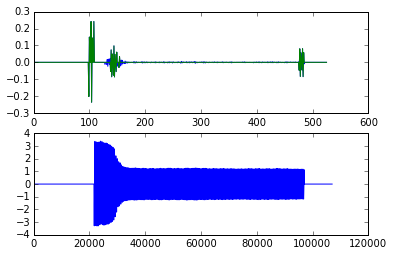

1421
2000


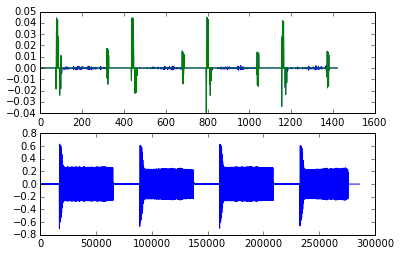

In [ ]:
for (k,v) in t_data[t].items():
    
    window_inputs = pd.DataFrame([item for item in toHybridWindows(addOffSequence(v)) if len(item) == numIn]).transpose()
    window_outputs = parseOutputs(window_inputs)
    outMean = np.mean(window_outputs)
    outStd = np.std(window_outputs)
    out = [o if abs(o - outMean) > outMean + outStd else 0 for o in window_outputs ]
    plt.subplot(211)
    plt.plot(window_outputs)
    plt.plot(out)
    plt.subplot(212)
    plt.plot(addOffSequence(v)['current'])
    plt.show()

Okay!

* At this point we have some reasonably clean "on" signals to go by.


* Our algorithm for marking needs to keep track of whether or not it's turned something on or off and it should only do each once for any given series. The "off" signal should come at the end of a signal, after a number of zeroes have been appended (probably 10,000). 


